# Brain age regression
#### Two main approachs, with all the data from all the runs and the other with the mean matrix correlation for each subject
# 1. Importing all data or Fisher transformed

In [1]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [2]:
from utils import import_data, compute_KNN_graph, create_graph, create_batch,reconstruct_symmetric_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error


%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scoring = {'mae': 'neg_mean_absolute_error',
           'mse': 'neg_mean_squared_error'} 
results = pd.DataFrame()

In [3]:
import pandas as pd

def remove_collinear_features(x, threshold):
    ''' Objective: Remove collinear features in a dataframe with a correlation coefficient greater than the threshold.
        Removing collinear features can help a model to generalize and improves the interpretability of the model.'''
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()

    # Extract the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]

    # Drop features 
    x = x.drop(to_drop, axis=1)
    
    return x

In [4]:
df, phenotypic = import_data(fisher=True)
df = df.join(pd.DataFrame(phenotypic.Age), how='left')
df = df.join(pd.DataFrame(phenotypic['ADHD Measure']), how='left')

df = ((df.reset_index()).drop(columns=['Institution', 'Subject'])).dropna(subset=[str(x) for x in range(0,17954)])
df = df.dropna(axis=0, subset=['Age'])

#df = remove_collinear_features(df,0.8)

from sklearn.utils import shuffle
df = shuffle(df, random_state=42)



# Real test set
TEST =  df.iloc[-30:]

df = df.iloc[:-30]

# Labels
y = (df.Age).apply(lambda x: int(x))

# Remove from Fisher-space
X = np.tanh(df.iloc[:,:-3])
X_TEST =  np.tanh(TEST.iloc[:,:-3])
y_TEST =  (TEST.Age).apply(lambda x: int(x))

In [5]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


## 2. Starting modelling

#### Linear Regression

In [6]:
from sklearn.model_selection import train_test_split

# Split train and validation set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, shuffle=True, random_state=42)

In [7]:
X_train.shape

(617, 17954)

In [8]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)
y_pred = reg.predict(X_test)

In [9]:
mean_absolute_error(y_test, y_pred)

1.606210878298379

In [10]:
from sklearn.model_selection import cross_val_score
scores = cross_validate(reg, X, y, cv=cv,scoring=scoring, n_jobs=-1)

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


In [11]:
print("MAE in test:%0.2f(%0.2f)" % (scores['test_mae'].mean(), scores['test_mae'].std()))
print("MSE in test {:.2f}({:.2f})".format(scores['test_mse'].mean(), scores['test_mse'].std()))

MAE in test:-1.50(0.15)
MSE in test -3.80(0.62)


In [12]:
scores['Model'] = ['Linear_Reg']*10
results = pd.concat([results, pd.DataFrame.from_dict(scores)],axis=1)

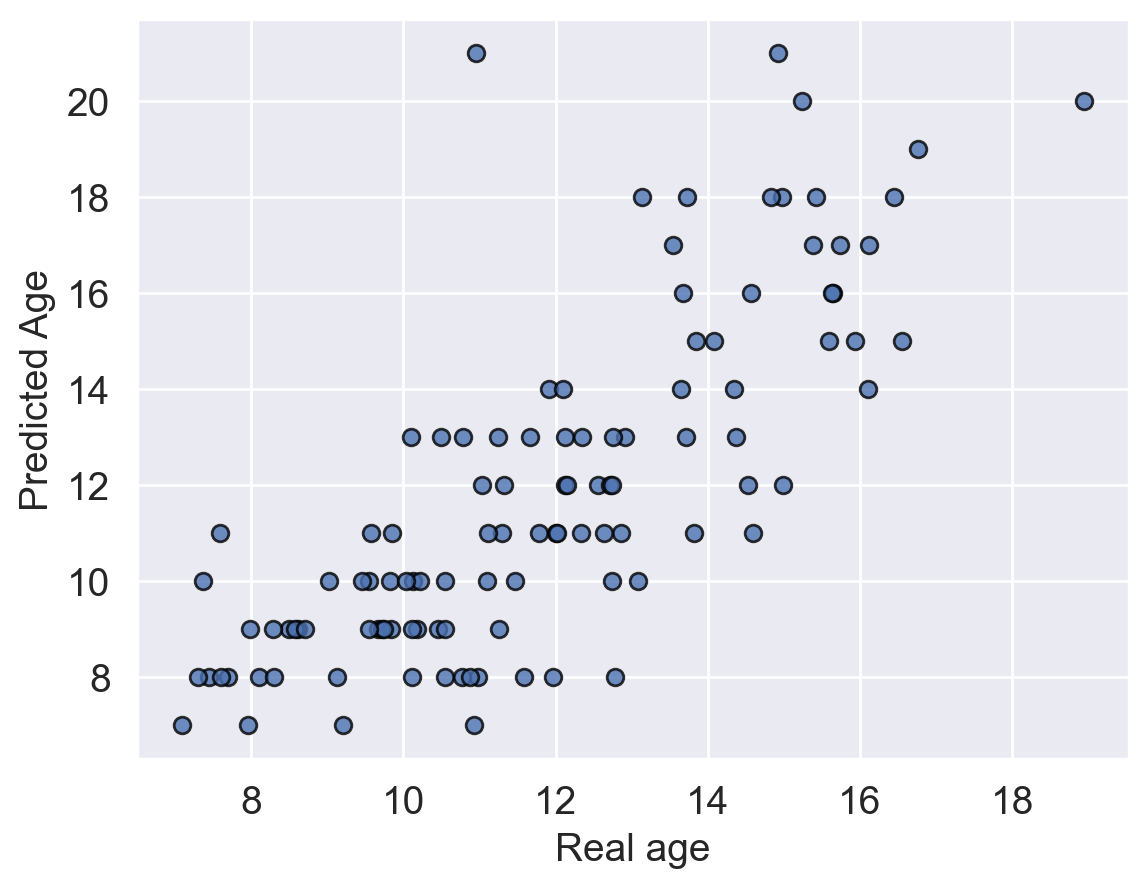

In [13]:
plt.figure(dpi=200)
plt.scatter(y_pred,y_test,alpha=0.8, edgecolors='black')
plt.ylabel('Predicted Age')
plt.xlabel('Real age')
plt.show()

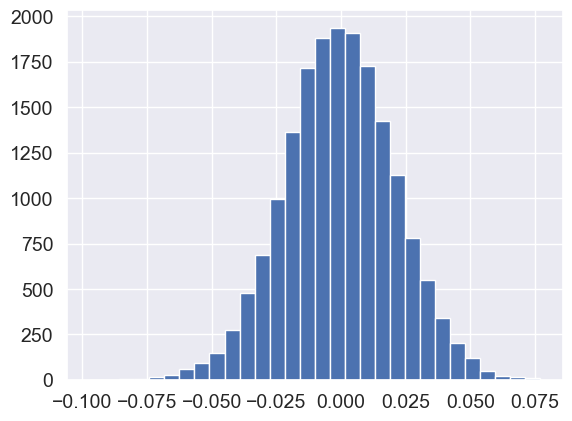

In [14]:
plt.hist(reg.coef_,bins=30)
plt.show()

In [ ]:
results.to_csv('/Users/rodrigo/Post-Grad/CC400/Results/linear_reg_age.csv')

### Lasso regularization

In [ ]:
from sklearn.model_selection import GridSearchCV

reg_reg = linear_model.Lasso()

alpha_range = [0.0001,0.0005,0.001]
param_grid =  dict(alpha = alpha_range)

grid = GridSearchCV(reg_reg, param_grid, cv=cv, scoring='neg_mean_absolute_error', return_train_score=True,verbose=0, n_jobs=-1)
grid_search=grid.fit(X_train, y_train.values.ravel())

In [ ]:
print(grid_search.best_params_)

In [ ]:
accuracy = grid_search.best_score_
print("mean absolute error : {:.2f}".format(accuracy) )

### After fiding the best hyper-parameter

In [ ]:
# Best xgboosting model
final_cl = linear_model.Lasso(
    **grid_search.best_params_
)
# **rf_random.best_params_

scores = cross_validate(final_cl, X_train, y_train.values.ravel(), scoring=scoring,
                         cv=cv, n_jobs=-1,verbose=1)

In [ ]:
print("MAE in test:%0.2f(%0.2f)" % (scores['test_mae'].mean(), scores['test_mae'].std()))
print("MSE in test {:.2f}({:.2f})".format(scores['test_mse'].mean(), scores['test_mse'].std()))

In [ ]:
plt.figure(dpi=200)
plt.scatter(y_test,y_pred,alpha=0.8, edgecolors='black')
plt.ylabel('Predicted Age')
plt.xlabel('Real age')
plt.title(('r = {:.2f}'.format(np.corrcoef(y_test,y_pred)[0,1])))
plt.show()

In [ ]:
df_aux = df.loc[list(y_test.index),:]
df_aux['Predicted Age'] = y_pred

In [ ]:
plt.figure(dpi=150)
sns.scatterplot(data=df_aux, x='Age', y='Predicted Age', hue='ADHD Measure')

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

#results = smf.ols('falsexam ~ format_ol', data=df).fit()
model = sm.OLS(y_train,X_train)
results = model.fit()
(results.summary().tables[1])

In [ ]:
from statsmodels.tools.tools import pinv_extended
import statsmodels.api as sm
import sklearn, statsmodels

def regression_analysis(X, y, model):
    
    is_statsmodels = False
    is_sklearn = False
    
    # check for accepted linear models
    if type(model) in [sklearn.linear_model._base.LinearRegression,
                       sklearn.linear_model._ridge.Ridge,
                       sklearn.linear_model._ridge.RidgeCV,
                       sklearn.linear_model._coordinate_descent.Lasso,
                       sklearn.linear_model._coordinate_descent.LassoCV,
                       sklearn.linear_model._coordinate_descent.ElasticNet,
                       sklearn.linear_model._coordinate_descent.ElasticNetCV,
                      ]:
        is_sklearn = True
    elif type(model) in [statsmodels.regression.linear_model.OLS, 
                         statsmodels.base.elastic_net.RegularizedResults,
                        ]:
        is_statsmodels = True
    else:
        print("Only linear models are supported!")
        return None
    
    
    
    has_intercept = False
    
    if is_statsmodels and all(np.array(X)[:,0]==1):
        # statsmodels add_constant has been used already
        has_intercept = True  
    elif is_sklearn and model.intercept_:
        has_intercept = True
        

    
    if is_statsmodels:
        # add_constant has been used already
        x = X
        model_params = model.params
    else: # sklearn model
        if has_intercept:
            x = sm.add_constant(X)
            model_params = np.hstack([np.array([model.intercept_]), model.coef_])
        else:
            x = X
            model_params = model.coef_
        
    #y = np.array(y).ravel()
    
    # define the OLS model
    olsModel = sm.OLS(y, x)
    
    pinv_wexog,_ = pinv_extended(x)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    
    
    return sm.regression.linear_model.OLSResults(olsModel, model_params, normalized_cov_params)
    

In [ ]:
from sklearn.linear_model import Ridge


skridge = Ridge(alpha=0.2, max_iter=9000, tol=1e-5, fit_intercept=True)
skridge.fit(X_train,y_train)

result = regression_analysis(X_train, y_train, skridge)
result.summary()

## Pycaret

In [ ]:
from pycaret.regression import *
s = setup(data=df, target = 'Age',fold_shuffle=True, session_id=2,preprocess=False)

In [ ]:
best_model = compare_models(include = ['lr', 'dt', 'lightgbm', 'br', 'huber', ])

In [ ]:
best_model

In [ ]:
evaluate_model(best_model)

In [ ]:
bayesian_bridge = create_model('br') 
tuned_bayesian_bridge = tune_model(bayesian_bridge)

In [ ]:
predictions = predict_model(tuned_bayesian_bridge)

In [ ]:
predictions.shape

In [ ]:
plt.figure(dpi=200)
plt.scatter(predictions.Age,predictions.Label,alpha=0.8, edgecolors='black')
plt.ylabel('Predicted Age')
plt.xlabel('Real age')
plt.show()